
$$
\begin{array}{ll}
\underset{\mathbf{p}, \mathbf{v}, \mathbf{a}}{\operatorname{min}} &\sum\limits_{i}^{\{x, y, z\}} \left( \sum\limits_{n=0}^{N}  
\|\mathbf{a}_n^i\|^2_2  + \|\mathbf{p}_N^i - \mathbf{p}^{i, \mathrm{d}}\|^2_2 +\|\mathbf{v}_N^i - \mathbf{v}^{i, \mathrm{d}}\|^2_2  \right)\\
\text { s.t.} & 
\mathbf{p_0} = \mathbf{p}_0^\mathrm{des};\mathbf{v_0} = \mathbf{v}_0^\mathrm{des} \\
& \mathbf{v}_n \in \mathcal{V}; \mathbf{a}_n \in \mathcal{A} \\
& \mathbf{p}_{n+1} = \mathbf{p}_n  +\mathbf{v}_n \mathrm{\Delta t} \\
& \mathbf{v}_{n+1} = \mathbf{v}_n + \mathbf{a}_n \mathrm{\Delta t} \\
& p_{n_k:n_{k+\xi}}^z = p_{\mathrm{height}} \quad \text{ (trapezoidal profile)}
\end{array}
$$

In [1]:
import numpy as np
import scipy.sparse as spa
import osqp
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix

In [2]:
Ts = 0.25
dt = 0.005
foot_height_keep = 0.2
N = int(Ts/dt)
nb_total_variables_per_coordinate = 3 * N # px, vx, zx
nb_total_variables = 3 * nb_total_variables_per_coordinate # x, y, z

### P, A, l, b matrices and vectors

In [3]:
# ======== Create P, q matrices ========
opt_weight_desired_pos = np.array([5500, 5500, 55000])
opt_weight_desired_vel = np.array([5500, 5500, 55000])
p_N_des = np.array([0.2, 0.2, 0.0])
v_N_des = np.zeros(3)

P = np.zeros((nb_total_variables, nb_total_variables))
q = np.zeros((nb_total_variables, 1))

for i in range(nb_total_variables_per_coordinate):
    P[i * 3 + 2, i * 3 + 2] = 0.001

for i in range(3):
    P[(i + 1) * nb_total_variables_per_coordinate - 3, (i + 1) * nb_total_variables_per_coordinate - 3] = opt_weight_desired_pos[i]
    P[(i + 1) * nb_total_variables_per_coordinate - 2, (i + 1) * nb_total_variables_per_coordinate - 2] = opt_weight_desired_vel[i]

    q[(i + 1) * nb_total_variables_per_coordinate - 3] = - opt_weight_desired_pos[i] * p_N_des[i]
    q[(i + 1) * nb_total_variables_per_coordinate - 2] = - opt_weight_desired_vel[i] * v_N_des[i]

P = csr_matrix(P)

# ======== Create A matrix ========
# boundary points
A_eq_pos_vel_des = csr_matrix((6, nb_total_variables))
A_eq_pos_vel_des[0, 0] = 1
A_eq_pos_vel_des[1, 1] = 1
A_eq_pos_vel_des[2, nb_total_variables_per_coordinate] = 1
A_eq_pos_vel_des[3, nb_total_variables_per_coordinate + 1] = 1
A_eq_pos_vel_des[4, 2 * nb_total_variables_per_coordinate] = 1
A_eq_pos_vel_des[5, 2 * nb_total_variables_per_coordinate + 1] = 1

# dynamics
block_dynamics = np.zeros((2, 6))
block_dynamics[0, 0] = 1
block_dynamics[0, 1] = dt
block_dynamics[0, 3] = -1
block_dynamics[1, 1] = 1
block_dynamics[1, 2] = dt
block_dynamics[1, 4] = -1
A_dynamics_size = (2 * N - 2, 3 * N)
A_dynamics_per_coordinate = np.zeros(A_dynamics_size)

j = 0
for i in range(int((2 * N - 2)/2)):
    A_dynamics_per_coordinate[j : j + 2, i * 3 : i * 3 + 6] = block_dynamics
    j = j + 2

size_rows_A = A_dynamics_per_coordinate.shape[0]
size_cols_A = A_dynamics_per_coordinate.shape[1]
A_dynamics = np.zeros((3 * size_rows_A, nb_total_variables))

for i in range(3):
    A_dynamics[i * size_rows_A : i * size_rows_A + size_rows_A, i * size_cols_A : i * size_cols_A + size_cols_A] = A_dynamics_per_coordinate
A_dynamics = csr_matrix(A_dynamics)

# limits for vel and acc
block = np.zeros((2, 3))
block[0, 1] = 1
block[1, 2] = 1
A_limits = np.zeros((nb_total_variables_per_coordinate * 2, nb_total_variables))

for i in range(nb_total_variables_per_coordinate):
    A_limits[2 * i:2 * (i+1), 3 * i:3 * (i+1)] = block

# foot height
T_keep = 33.333/100*Ts
T_start_keep = 33.333/100*Ts
T_end_keep = T_keep + T_start_keep
n_keep = int(T_keep/dt)
n_start_keep = int(T_start_keep/dt)
n_end_keep = n_keep + n_start_keep

A_keep_foot = lil_matrix((n_keep, nb_total_variables))
j = n_start_keep
for i in range(n_keep):
    A_keep_foot[i, 2*nb_total_variables_per_coordinate + 3*j] = 1
    j = j + 1

A_total = spa.vstack([A_eq_pos_vel_des,
                    A_dynamics,
                    A_limits,
                    A_keep_foot], format='csc')

/usr/lib/python3/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [4]:
# ======== Create l, u matrices ========
# boundary points
p0_desired = 0.0
v0_desired = 0.0
l_boundary_pts_per_coordinate = np.zeros((2, 1))
u_boundary_pts_per_coordinate = np.zeros((2, 1))
l_boundary_pts_per_coordinate[0:2] = np.array([[p0_desired], [v0_desired]])
u_boundary_pts_per_coordinate[0:2] = np.array([[p0_desired], [v0_desired]])

l_boundary_pts = np.vstack([l_boundary_pts_per_coordinate] * 3)
u_boundary_pts = np.vstack([u_boundary_pts_per_coordinate] * 3)

# dynamics
l_dynamics_per_coordinate = np.zeros((2 * N - 2, 1))
u_dynamics_per_coordinate = np.zeros((2 * N - 2, 1))
l_dynamics = np.vstack([l_dynamics_per_coordinate] * 3)
u_dynamics = np.vstack([u_dynamics_per_coordinate] * 3)

# limits
v_max = 10.0
a_max = 150.0
l_limits_per_coordinate = np.zeros((2 * N, 1))
u_limits_per_coordinate = np.zeros((2 * N, 1))
l_limits_per_coordinate[0::2] = -v_max
l_limits_per_coordinate[1::2] = -a_max
u_limits_per_coordinate[0::2] = v_max
u_limits_per_coordinate[1::2] = a_max

l_limits = np.vstack([l_limits_per_coordinate] * 3)
u_limits = np.vstack([u_limits_per_coordinate] * 3)

# foot height
l_keep = foot_height_keep*np.ones((n_keep, 1))
u_keep = foot_height_keep*np.ones((n_keep, 1))

l_total = np.vstack([l_boundary_pts,
                     l_dynamics,
                     l_limits,
                     l_keep])
u_total = np.vstack([u_boundary_pts,
                     u_dynamics,
                     u_limits,
                     u_keep])

In [5]:
prob = osqp.OSQP()
max_iter = 200000
eps_abs = 1.0e-05
eps_rel = 1.0e-05
prob.setup(P, q, A_total, l_total, u_total, max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel)
results = prob.solve()

x_opt = results.x
pos_opt_x = x_opt[::3][0 : N]
pos_opt_y = x_opt[::3][N : 2 * N]
pos_opt_z = x_opt[::3][2 * N : 3 * N]

vel_opt_x = x_opt[1::3][0 : N]
vel_opt_y = x_opt[1::3][N : 2 * N]
vel_opt_z = x_opt[1::3][2 * N : 3 * N]

acc_opt_x = x_opt[2::3][0 : N]
acc_opt_y = x_opt[2::3][N : 2 * N]
acc_opt_z = x_opt[2::3][2 * N : 3 * N]

/home/sorina/.local/lib/python3.10/site-packages/osqp/utils.py:118: UserWarning: Converting sparse P to a CSC (compressed sparse column) matrix. (It may take a while...)
  warn("Converting sparse P to a CSC " +


-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 450, constraints m = 616
          nnz(P) + nnz(A) = 1360
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 200000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.6876e+02   2.00e-01   4.38e+03   1.00e-01   5.28e-04s
 200   1.1460e+03   1.58e+00   5.59e-01   1.63e-03   2.81e-03s
 400   6.4572e+02   2.91e-02   1.37e-01   

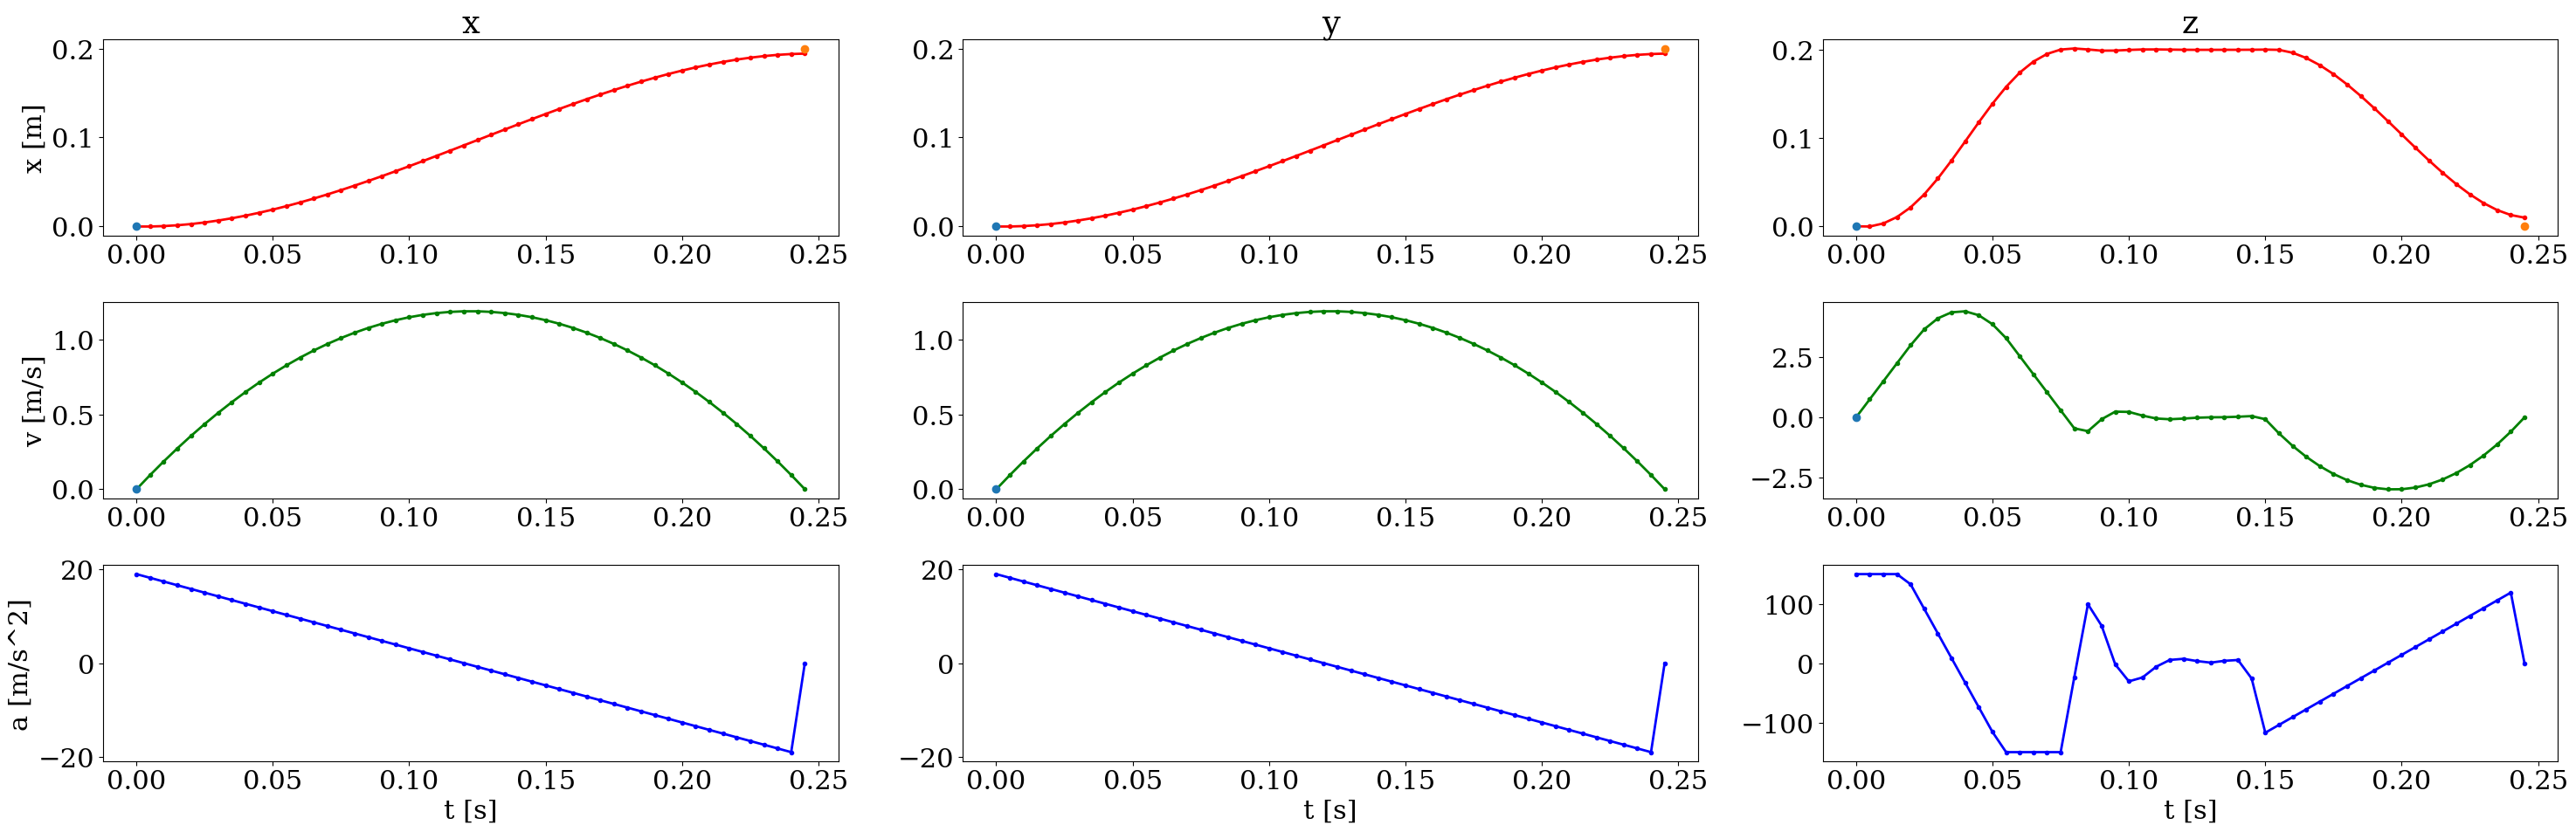

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 22,
    'font.family': 'serif',
    'mathtext.default': 'regular',
    'axes.labelsize': 22,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'legend.fontsize': 22,
    'figure.titlesize': 22,
    'lines.linewidth': 2,
})

fig, axs = plt.subplots(3, 3, figsize=(30, 10))
t = np.arange(0, Ts, dt)
axs[0, 0].set_title('x')
axs[0, 0].plot(t, pos_opt_x, '.-r', label='pos')
axs[0, 0].plot(0, p0_desired, 'o')
axs[0, 0].set_ylabel('x [m]')
axs[0, 0].plot(t[-1], p_N_des[0], 'o')
axs[1, 0].plot(t, vel_opt_x, '.-g', label='vel')
axs[1, 0].plot(0, v0_desired, 'o')
axs[1, 0].set_ylabel('v [m/s]')
axs[2, 0].plot(t, acc_opt_x, '.-b', label='acc')
axs[2, 0].set_ylabel('a [m/s^2]')
axs[2, 0].set_xlabel('t [s]')

axs[0, 1].set_title('y')
axs[0, 1].plot(t, pos_opt_y, '.-r', label='pos')
axs[0, 1].plot(0, p0_desired, 'o')
axs[0, 1].plot(t[-1], p_N_des[1], 'o')
axs[1, 1].plot(t, vel_opt_y, '.-g', label='vel')
axs[1, 1].plot(0, v0_desired, 'o')
axs[2, 1].plot(t, acc_opt_y, '.-b', label='acc')
axs[2, 1].set_xlabel('t [s]')

axs[0, 2].set_title('z')
axs[0, 2].plot(t, pos_opt_z, '.-r', label='pos')
axs[0, 2].plot(0, p0_desired, 'o')
axs[0, 2].plot(t[-1], p_N_des[2], 'o')
axs[1, 2].plot(t, vel_opt_z, '.-g', label='vel')
axs[1, 2].plot(0, v0_desired, 'o')
axs[2, 2].plot(t, acc_opt_z, '.-b', label='acc')
axs[2, 2].set_xlabel('t [s]')

plt.tight_layout()
# [a.legend() for a in axs]
plt.show()